In [1]:
import sys
import warnings
warnings.filterwarnings(action='ignore')
import collections
from IPython.display import display
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split

mpl.rcParams['axes.unicode_minus'] = False
font_fname = '/Users/seongdae/Library/Fonts/NanumGothicLight.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc('font', family=font_name)
# size, family
print ('font size : '+str(plt.rcParams['font.size']) )
print ('font family : '+str(plt.rcParams['font.family']) )
# import default setting
print('python version : {0}\npandas version : {1}\nmatplotlib version : {2}\nnumpy version : {3}\n'
.format(sys.version, pd.__version__, mpl.__version__, np.__version__))

font size : 10.0
font family : ['NanumGothic']
python version : 3.7.6 (v3.7.6:43364a7ae0, Dec 18 2019, 14:18:50) 
[Clang 6.0 (clang-600.0.57)]
pandas version : 0.25.3
matplotlib version : 3.1.2
numpy version : 1.18.1



# 결정 트리의 앙상블

In [2]:
## 결정트리의 과적합 문제를 극복하고자 앙상블 기법 사용
# ensemble, 여러 머신러닝 모댈을 연결하여 더 강력한 모델을 만드는 기법
# 회귀 문제 해결을 위한 대표적 두가지 머신러닝 모델
    # 랜덤 포레스트(random forest), 그래디언트 부스팅(gradinet boosting) 결정트리
    # 모델을 구성하는 기본 요소가 결정트리

## 랜덤 포레스트

In [3]:
# 결정트리의 주요 단점, 훈련 데이터에 과대적합 되는 경향이 있음
# 기본적으로, 조금씩 다른 여러 결정 트리의 묶음
    # 각 트리는 비교적 예측이 용이하나, 데이터의 일부에 과적합 하는 경향을 가지는데 기초함
    # 예컨대, 잘 작동하되 서로 다른 방향으로 과적합된 트리를 많이 만들면, 그 결과를 평균냄으로서 과적합된 양을 줄일 수 있다는 아이디어
# 이 전략을 구현하려면 결정 트리를 많이 만들어야하며, 각 트리는 타깃 예측을 잘 해야하며, 다른 트리와는 구별되어야 의미가 생김
# 이름처럼 랜덤 포레스트는 트리들이 달라지도록, 생성 시 무작위성을 주입함
    # 1. 트리를 만들 때 데이터 포인트르를 무작위로 선택하게끔 하거나
    # 2. 분할 테스트에서 특성을 무작위로 선택하게끔 함

### 랜덤 포레스트 구축

In [4]:
# 랜덤 포레스트를 만들 때, 생성할 트리의 갯수를 정해야함
    # RandomForestRegressor 나 RandomForestClassifier 의 n_estimators 매개변수(Default : 10, .22ver부턴 100)
# 트리들은 완전히 독립적으로 만들어져야 하므로, 각 트리가 고유하게 만들어지도록 무작위한 선택을함
# 알고리즘은 트리를 만들기 위해 먼저 데이터의 '부트스트랩 샘플'(bootstrap sample)을 생성함
    # n_samples개의 데이터 포인트 중에서 무작위로 n_samples 횟수만큼 반복 추출함
    # 한 샘플이 여러번 중복해서 추출되거나, 어떤 샘플은 한번도 추출당하지 않을 수 있음(대략 1/3정도)
        # 100개 샘플 중에 어떤 하나가 선택되지 않을 확률은(횟수당 하나를 추출함) 0.99%
        # 이를 제외하지 않고, 100번 반복하면 (0.99)^100 = 0.366
# 이렇게 만들어진 데이터셋으로 결정트리를 만듬

In [5]:
# 결정트리를 만들때 이전과는 다른 알고리즘을 가짐
# 각 노드에서 전체 특성을 대상으로 최선의 테스트를 찾는 것이 아닌
# 알고리즘이 각 노드에서 후보 특성을 무작위로 선택한 후, 이 후보 특성들 중에서 최선의 테스트를 찾음
    # 각 후보 특성을 선택할 때, 몇개의 특성을 고를지 max_featues 매개변수로 조절할 수 있음
    # 후보 특성을 고르는 것은 매 노드마다 반복됨, 트리의 각 노드는 각자 다른 후보 특성들을 사용하여 테스트를 만듬

In [6]:
# 부트스트랩 샘플링은 랜덤 포레스트의 트리들이 조금씩 다른 데이터셋을 이용해 만들어지도록 하고
# 각 노드에서 특성의 일부들만 사용하기 때문에
# 트리의 각 분기들은 각기 다른 특성 부분 집합을 사용함

# 이 두 매커니즘이 합쳐져서 랜덤 포레스트의 모든 트리가 서로 달라짐

In [7]:
# 이 방식에서 max_features 매개변수가 중요함
    # max_features 를 n_features(최대값) 로 지정하면, 트리의 각 분기에서 모든 특성을 고려하므로
    # 특성 선택에 무작위성이 들어가지 않아 의미가 없어짐(하지만 부트스트랩 샘플링으로 인한 데이터 무작위성은 유지)
    
    # max_features 를 1(최소값) 로 지정하면, 트리의 분기는 테스트 할 특성을 고를 필요가 없어짐(그냥 뽑히는 특성 하나를 씀)
    # 그냥 무작위로 선택된 특성의 임계값을 찾기만 함
    
    # max_features 값이 커진다면, 랜덤 포레스트의 트리들은 각자 매우 비슷해지고, 가장 두드러진 특성을 이용해 데이터에 맞춰질(학습될) 것
    # max_features 값이 낮아지면, 랜덤 포레스트의 트리들은 각자 매우 달라지고, 각 트리들은 데이터에 맞추기 위해서 깊이가 깊어질 것
# 랜덤 포레스트로 예측을 할 때는 먼저 알고리즘이 모델에 있는 모든 트리의 예측을 만듬
# 회귀의 경우 : 이 예측들을 평균하여 최종 예측을 만듬
# 분류의 경우 : 약한 투표 전략을 사용
    # 각 알고리즘이 가능성 있는 출력 레이블의 확률을 제공함으로써 간접적인 예측을함
    # 트리들이 예측한 확률을 평균내어 가장 높은 확률을 가진 클래스가 예측값(분류)가 됨

#### two_moon dataset 사용, 트리 5개로 구성된 랜덤 포레스트 모델

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

forest = RandomForestClassifier(n_estimators=5, random_state=2).fit(X_train, y_train)

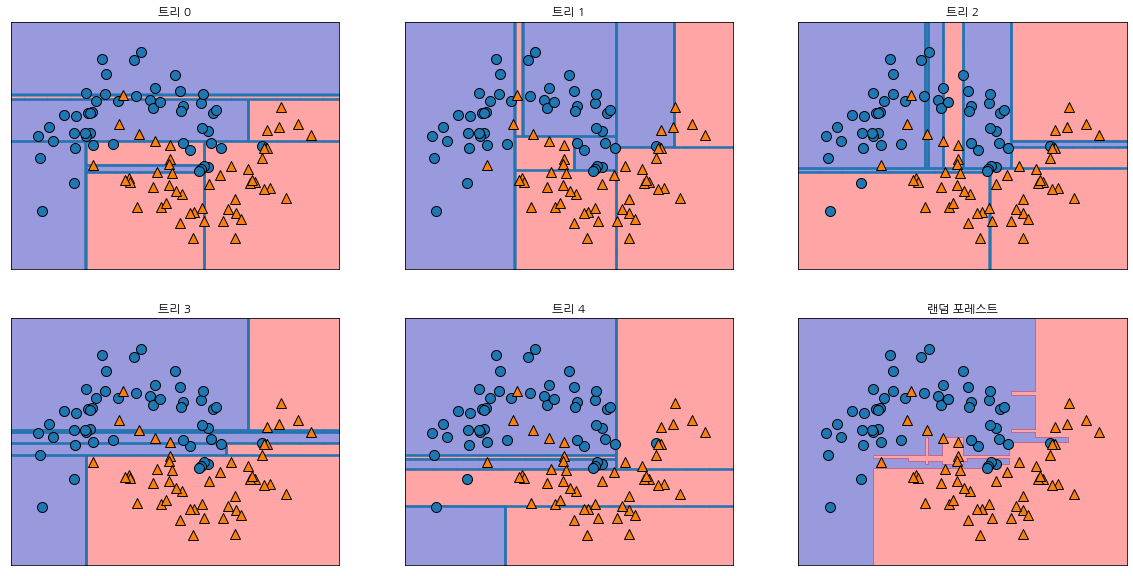

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):# estimators_ 에는 내부의 각 트리가 들어가있음
    ax.set_title('트리 {}'.format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)
# 각 개별적 트리    
mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
# 랜덤포레스트 트리
axes[-1,-1].set_title('랜덤 포레스트')
mglearn.discrete_scatter(X[:,0], X[:,1], y) # 안적으면 o, ^ 그래프에 안찎힘

In [10]:
# 다섯 개의 트리가 각자 만든 결정 경계는 확연히 다름
# 부트스트랩 샘플링 때문에, 각 트리마다 등장하는 데이터 포인터가 다르기에 트리가 불완전함
# 랜덤 포레스트의 경우 (마지막 그래프) 개개의 트리보다는 덜 과적합되고, 훨씬 좋은 결정 경계를 가짐
# 실제 application 에서는 수백, 수천개의 트리를 가지기 때문에 더 부드러운 결정 경계가 만들어짐

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.929


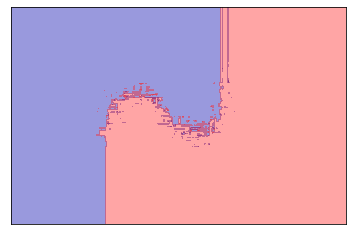

In [11]:
# 10000 개의 데이터, 100개의 트리의 경우, 완만한 결정 경계를 가지는것을 볼 수 있음
X, y = make_moons(n_samples=10000, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

forest_100 = RandomForestClassifier(n_estimators=100, random_state=2).fit(X_train, y_train)
mglearn.plots.plot_2d_separator(forest_100, X, fill=True, alpha=0.4)
print('훈련 세트 정확도 : {:.3f}'.format(forest_100.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.3f}'.format(forest_100.score(X_test, y_test)))

#### 유방암 데이터셋, 100개 트리

In [12]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
forest_cancer = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
print('훈련 세트 정확도 : {:.3f}'.format(forest_cancer.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.3f}'.format(forest_cancer.score(X_test, y_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.972


In [13]:
# 별다른 매개변수 튜닝 없이 선형 모델이나 단일 트리보다 높은 97% 정확도를 보여줌
# 단일 결정트리에서 한 것 과 같이 max_features 매개변수를 조정하거나, 사전가지치기를 할 수 있음
# 그러나 기본설정에서도 좋은 결과를 보여줄 때가 많음

In [14]:
# 랜덤 포레스트도 특성 중요도를 제공함, 각 트리의 특성 중요도를 취합하여 계산한 것
# 일반적으로 랜덤포레스트에서 제공하는 특성 중요도가 하나의 트리에서 제공하는 특성 중요도보다 신뢰도가 높음

특성 중요도 : 
[0.02515433 0.01563844 0.05372655 0.04861645 0.00769078 0.00936994
 0.05539489 0.10305394 0.0065771  0.00282708 0.02921459 0.00607814
 0.01342868 0.03420174 0.00360641 0.00432096 0.00448775 0.00657502
 0.00460597 0.00627095 0.11657269 0.01603133 0.16027724 0.0634688
 0.01356448 0.01164113 0.03923725 0.11711756 0.01164259 0.00960721]


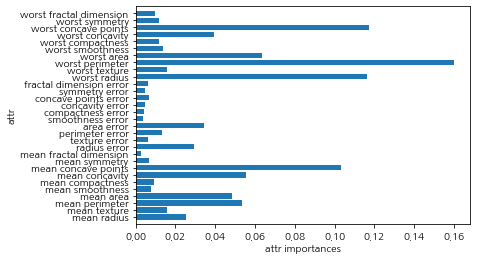

In [15]:
print("특성 중요도 : \n{}".format(forest_cancer.feature_importances_))
# 특성 중요도 시각화 하기
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("attr importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)
plot_feature_importances_cancer(forest_cancer)
plt.show()

In [16]:
# 단일 트리의 경우보다 훨씬 많은 특성이 0이상의 값(유의미한)의 중요도를 가짐
# 단일 트리와 마찬가지로 worst radius 특성의 importances 가 높지만, 가장 높은 값(중요하다 판단하는)은  worst perimeter를 선택함
# 랜덤 포레스트를 만드는 무작위성은 알고리즘이 가능성이 있는 많은 경우를 고려할 수 있게 만듬
    # ≈ 랜덤 포레스트가 단일 트리보다 더 넓은 시각으로 데이터를 바라 볼 수 있게 함

## 장단점과 매개변수

In [17]:
# 장점, 단점
# 회귀와 분류에 있어서 랜덤 포레스트는 꽤나 높은 성능을 보임
# 매개변수 튜닝을 많이 하지 않아도 비교적 잘 작동함, 데이터의 스케일을 맞출 필요도 없음
# 전체적으로 단일 트리의 단점을 보완하고, 장점을 그대로 가지고 있음
    # 만약 의사 결정 트리를 간소하게 표현한다면, 단일 트리를 사용 하는게 나을 수도 있음
    # 수십, 수백개의 트리를 자세히 분석하기 어렵고, 랜덤 포레스트의 트리는(특성의 일부만 사용하기 때문에) 결정 트리보다 더 깊어지는 경향이 있기 때문에
    # 비전문가에게 시각적으로 보여주고 싶다면 단일 트리가 더 효과적..
# 대량의 데이터 셋에서 랜덤 포레스트는 시간이 걸릴 수 있음, 그러나 CPU 코어가 많다면 손쉽게 병렬 처리 할 수 있음
    # n_jobs 매개변수를 이용하여 사용 코어 갯수 설정 가능, n_jobs = -1 이라면 모든 코어를 사용

# 주의점
# 랜덤 포레스트는 말그대로 랜덤함
    # random_state를 변경하거나,지정하지 않으면 전혀 다른 모델이 만들어짐
    # 랜덤 포레스트의 트리의 갯수가 많을 수록, random_state 값의 변화에 따른 변동이 적음
# 텍스트 데이터 같이 매우 차원이 높고 희소한 데이터의 경우는 잘 작동하지 않음, 이런 경우 선형 모델이 더 적합함
# 랜덤 포레스트는 매우 큰 데이터셋에도 잘 작동하며, 훈련을 여러 CPU 코어로 간단하게 병렬 연산 할 수 있음(GPU사용x)
# 랜덤 포레스트는 선형 모델보다 많은 메모리를 사용하며 훈련과 예측이 느림
    # 속도와 메모리에 제한이 있다면 선형 모델이 더 나을 수 도 있다
    
# n_estimators, max_features 중요 매개변수, max_depth 와 같은 사전 가지치기 매개변수를 설정 할 수 있음
    # n_estimators 는 클수록 좋음, 많으면 많을 수록 많은 트리를 평균하여, 과적합을 줄이고 안정적인 모델을 만듬
    # 그러나 메모리와 긴 훈련시간이 필요하여 조절이 중요함, 가용할 수 있는 시간과 메모리만큼 많이 만드는게 좋음
    
    # max_features는 각 트리가 얼마나 무작위가 될 지를 결정하며 작은 max_features는 과대적합을 줄여줌
    # 일반적으로 기본값을 사용하는게 (max_features=auto) 좋은 방법이며
    # classifier에선 sqrt(n_features), Regression 에선 n_features 값을 그대로 가짐

# max_features니 max_leaf_node 매개변수를 추가하면 가끔 성능이 향상되기도 하며, 필요한 오버헤드(메모리, 훈련시간)을 줄일 수도 있음


## 번외. 외삽(extrapolation) 예측 문제

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


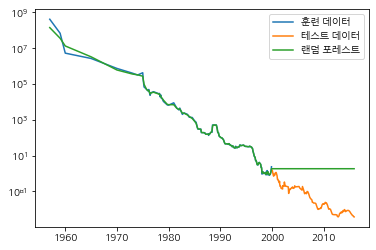

In [18]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'ram_price.csv'))
data_train = ram_prices[ram_prices.date<2000]
data_test = ram_prices[ram_prices.date>=2000]
# 훈련, 테스트 날짜기준 분리
from sklearn.ensemble import RandomForestRegressor

X_train = data_train.date[:, np.newaxis]
X_test = data_test.date[:, np.newaxis]
# 가격 예측 위해서 날짜 특성만 이용
y_train = np.log(data_train.price)
y_test = np.log(data_test.price)
# 데이터와 타깃 사이의 관계를 좀 더 간단하게 하기 위해 로그 스케일로 바꿈

forest_ram = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs= -1).fit(X_train, y_train)

X_all = ram_prices.date[:, np.newaxis]
# 전체 기간에 대해서 예측 수행
pred_forest = forest_ram.predict(X_all)
# 예측

price_forest = np.exp(pred_forest)

plt.semilogy(data_train.date, data_train.price, label = '훈련 데이터')
plt.semilogy(data_test.date, data_test.price, label = '테스트 데이터')
plt.semilogy(ram_prices.date, price_forest, label = '랜덤 포레스트')
plt.legend(loc='best')

In [19]:
# 외삽에 대한 문제는 아직 극복하지 못함, 훈련 데이터 내부에서만..

In [20]:
print('훈련 데이터 점수 : {:.2f}'.format(forest_ram.score(X_train, y_train)))
print('테스트 데이터 점수 : {:.2f}'.format(forest_ram.score(X_test, y_test)))
print('전체 데이터 점수 : {:.2f}'.format(forest_ram.score(X_all, price_forest)))

훈련 데이터 점수 : 1.00
테스트 데이터 점수 : -4.59
전체 데이터 점수 : -0.01


In [21]:
forest_ram

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)